Correlation of branch morphology and connection counts


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import itertools
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from os.path import exists, expanduser
import sys

sys.path.append(expanduser('~/src/cx-analysis/src'))
from src.skeleton_morphology import run_morphology_analysis, find_leaf_nodes
from src.connectome import Connectome
from src.utils import load_preprocessed_connectome, yymmdd_today
#from src.node_ops import segment_skeleton, find_end_points, find_central_segment, measure_path_lengths, measure_seg_distances
from vis.fig_tools import subtype_cm

plt.rcdefaults()
plt.style.use('vis/lamina.mplstyle')

c = subtype_cm()
m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

In [3]:
tp = '210511'
C = load_preprocessed_connectome(f"~/Data/{tp}_lamina/")

lamina_links = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_linkdf.pickle')
subtypes = np.unique([*lamina_links["pre_type"], *lamina_links["post_type"]])

all_ctypes = [p for p in itertools.product(subtypes, subtypes)]  
all_ctype_labels = [f"{pre}->{post}" for pre, post in all_ctypes]
ommatidia = ommatidia = np.unique(lamina_links['pre_om'])

df_lamina = pd.DataFrame(index=ommatidia, columns=all_ctype_labels).astype('Int64')

for om, row in df_lamina.iterrows():
    for c in all_ctype_labels:
        pre_t, post_t = c.split('->')
        # Cartridges on the posterior edge lack L4, so their counts for these connections are NaNed 
        if om in ['B0', 'E4', 'E5', 'E6', 'E7', 'D2', 'C1'] and post_t == 'LMC_4':
            df_lamina.loc[om, c] = None
        else:
            df_lamina.loc[om, c] = sum((lamina_links.pre_om == om) & (lamina_links.post_om == om) & 
                                       (lamina_links.pre_type == pre_t) & (lamina_links.post_type == post_t))

Pickle loaded from: /mnt/home/nchua/Data/210511_lamina/210511_preprocessed.pickle


In [4]:
df_lamina.head()

,LMC_1->LMC_1,LMC_1->LMC_2,LMC_1->LMC_3,LMC_1->LMC_4,LMC_1->LMC_N,LMC_1->R1R4,LMC_1->R2R5,LMC_1->R3R6,LMC_1->R7,LMC_1->R7p,...,centri->LMC_4,centri->LMC_N,centri->R1R4,centri->R2R5,centri->R3R6,centri->R7,centri->R7p,centri->R8,centri->UNKNOWN,centri->centri
A0,0,0,0,0,0,0,0,0,0,0,...,2,0,3,18,1,5,15,23,0,3
A1,0,0,0,0,0,0,0,0,0,0,...,4,1,2,14,1,1,22,13,0,1
A2,0,0,0,0,0,0,0,0,0,0,...,4,0,0,8,0,0,15,11,0,0
A3,0,0,0,0,0,0,0,0,0,0,...,3,0,0,19,0,7,32,26,0,4
A4,0,0,0,0,0,0,0,0,0,0,...,11,1,1,28,0,18,27,15,0,5


In [5]:
results_file = expanduser(f'~/Data/{tp}_lamina/210419_lmc-morphology.json')
lmc_sts = ['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4', 'LMC_N']#, 'LMC_3', 'LMC_4']#, 'LMC_N']#, 'R7', 'R8', 'R7p']
lmc_ids = [s for s, data in C.skel_data.items() if data.subtype in lmc_sts]
lmc_names = [data.name for s, data in C.skel_data.items() if s in lmc_ids]

if exists(results_file):
    with open(results_file, 'r') as fh:
        d = json.load(fh)
        segments, central_segs, seg_lens, seg_dists, strahler = d['segments'], d['central_segs'], d['seg_lengths'], d['seg_distances'], d['strahler']
else:
    segments, central_segs, seg_lens, seg_dists, strahler = run_morphology_analysis(C, lmc_ids, 
                                                                                    restrict_tags='lamina_end', 
                                                                                    save_file=results_file, 
                                                                                    verbose=False)

In [6]:
summary = []
for s in lmc_ids:
    data = C.skel_data[s]
    n_leaves = find_leaf_nodes(data.skel_nodes)
    summary.append({'name': data.name,
                    'skel_id': data.skel_id,
                    'om': data.group,
                    'subtype': data.subtype,
                    'n_central_nodes': len(central_segs[s]), 
                    'n_nodes': len(data.skel_nodes) - len(data.r_nodes), 
                    'n_segments': len(segments[s]),
                    'n_leaves': len(n_leaves),
                    'total_path_len': sum([v for k, v in seg_lens[s].items()]), 
                    'strahler_num': max([v for k, v in strahler[s].items()])})
    
cell_df = pd.DataFrame(summary).set_index('skel_id')

In [7]:
### EXCLUDE KNUBS ? ###
exclude_so1 = False

seg_data = []
major_seg = []

def div(num, denom):
    
    if denom == 0:
        return np.nan
    else:
        return float(num)/float(denom)

for s, segmented in segments.items():
    for seg_ind, seg in segmented.items():
        if int(seg_ind) in central_segs[s]:  # seg_ind = seg[1]
            #print(f"skip {seg_ind}")
            continue
        #elif (int(seg[0]) in central_segs[s]) and strahler[s][str(seg[-1])] == 1:
        elif exclude_so1 and (int(seg[0]) in central_segs[s]) and (strahler[s][str(seg[-1])] == 1):
            continue
        else:
            strahl_ind = str(seg[-1])  
            # strahler[s] is indexed by last node of the segment  
            this_seg = {'skel_id': str(s),
                         'name': cell_df.loc[s, 'name'], 
                         'subtype': cell_df.loc[s, 'subtype'],
                         'ind': seg_ind,
                         'dist': seg_dists[s][seg_ind], 
                         'len': seg_lens[s][seg_ind],
                         'tortuosity': div(seg_lens[s][seg_ind], seg_dists[s][seg_ind]), 
                         'strahl_ord': strahler[s][strahl_ind]}
            seg_data.append(this_seg)
            if int(seg[0]) in central_segs[s]:
                major_seg.append(this_seg)

seg_df = pd.DataFrame(seg_data)
major_df = pd.DataFrame(major_seg)

major_branches = []

for n, segs in major_df.groupby('name'):
    om = n[2:4]
    assert(n[5] == 'L')
    st = 'LMC_' + n[6]
    data = {'name': n,
            'skel_id': segs.iloc[0].skel_id,
            'subtype': segs.iloc[0].subtype,
            'n_major': len(segs), 
            'mean_strahl': segs['strahl_ord'].mean(), 
            'median_strahl': segs['strahl_ord'].median(), 
            'total_inputs': df_lamina.filter(regex='->' + st).loc[om].sum(), 
            'R1-6_inputs': df_lamina.filter(regex='R\dR\d->' + st).loc[om].sum(), 
            'R1436_inputs': df_lamina.filter(regex='R[13]R[46]->' + st).loc[om].sum(),
            'R25_inputs': df_lamina.filter(regex='R2R5->' + st).loc[om].sum(), 
            'R25_bias': div(df_lamina.filter(regex='R2R5->' + st).loc[om].sum(), df_lamina.filter(regex='R[13]R[46]->' + st).loc[om].sum())}
    major_branches.append(data)
    
major_branches = pd.DataFrame(major_branches).set_index('name')

In [8]:
major_df.head()

,skel_id,name,subtype,ind,dist,len,tortuosity,strahl_ord
0,25,omB6_LN,LMC_N,499512,1943.862490,2243.343122,1.154065,1
1,25,omB6_LN,LMC_N,276246,570.316018,340.400000,0.596862,1
2,25,omB6_LN,LMC_N,288328,1638.405872,1446.112083,0.882634,1
3,150,omE7_LN,LMC_N,414719,1762.331513,1115.437950,0.632933,1
4,150,omE7_LN,LMC_N,414716,658.147370,680.596582,1.034110,1


<ipython-input-9-04a7593edba6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(np.arange(0, 10, 2))


Text(0.5, 0.98, 'Mean strahler order of main branches')

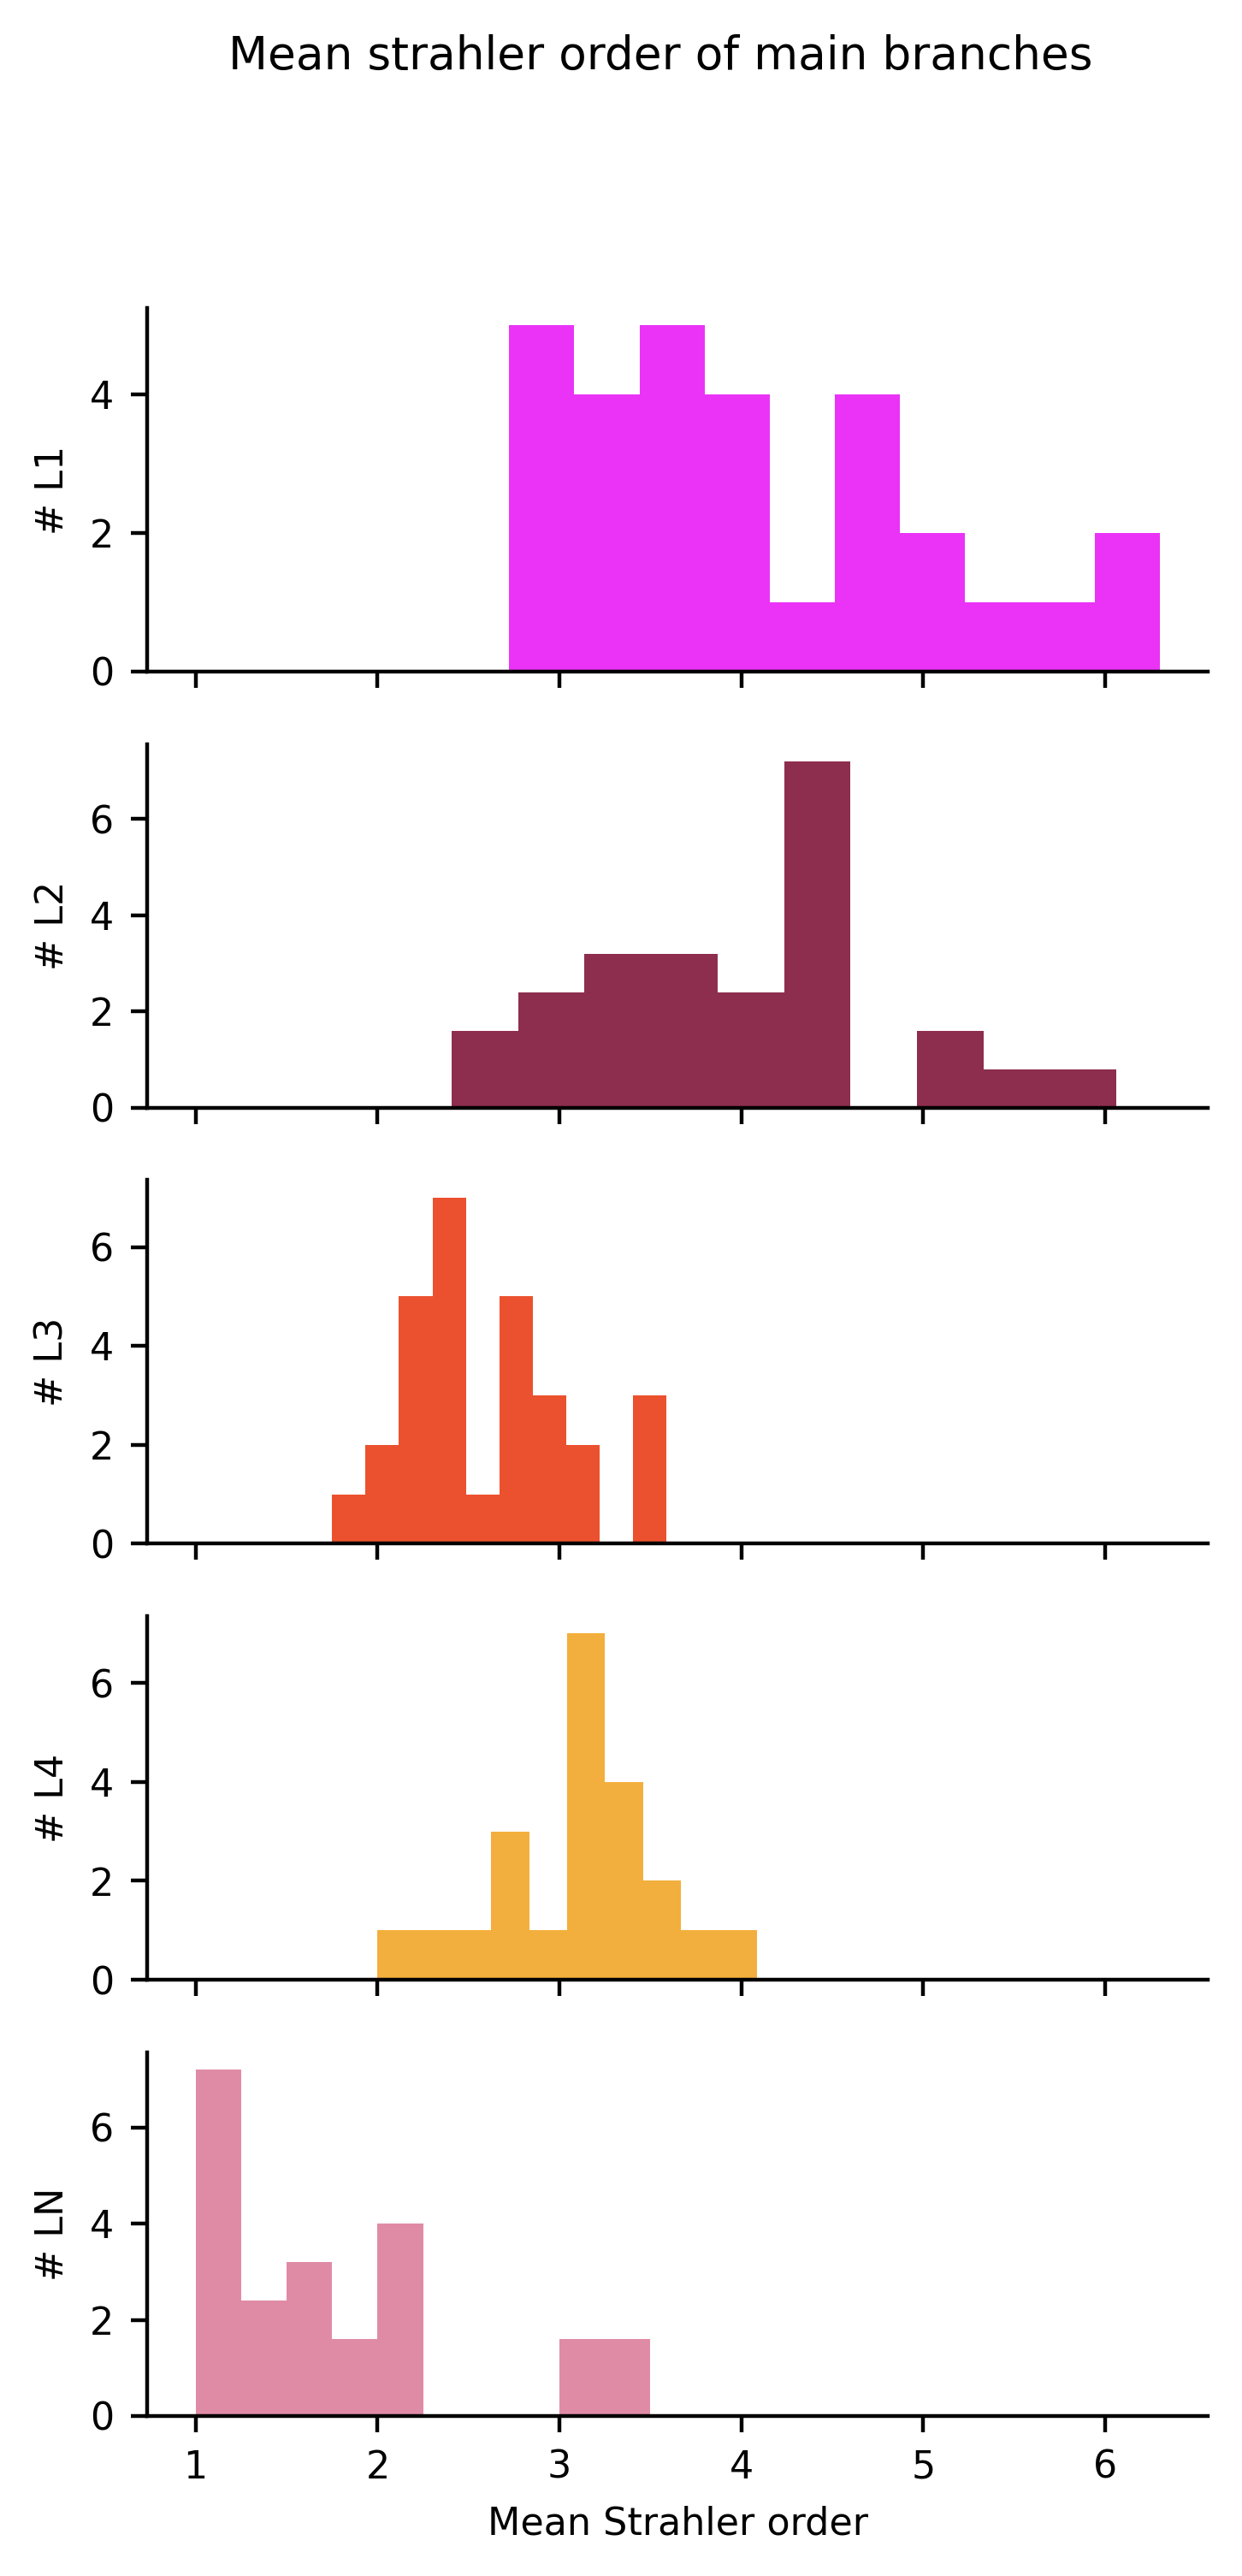

In [9]:
fig, axes = plt.subplots(5, sharex=True, figsize=[4, 8])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0
cm = subtype_cm()
for st, neurons in major_branches.groupby('subtype'):
    data = neurons['mean_strahl']
    
    axes[i].hist(data, color=cm[st])
    axes[i].set_ylabel(f"# {st[0] + st[-1]}")
    axes[i].set_yticklabels(np.arange(0, 10, 2))
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1
#     sns.histplot(segs, x='len', ax=axes[i, 1])
#     sns.histplot(segs, x='strahl_ord', ax=axes[i, 2])
axes[-1].set_xlabel('Mean Strahler order')
fig.suptitle('Mean strahler order of main branches')



In [10]:
### Total path length of major branches ###


total_branch_len = []
for skel, data in major_branches.iterrows():
    skel_id = data['skel_id']
    x = sum([d for i, d in seg_lens[skel_id].items() if i not in central_segs[skel_id]])
    total_branch_len.append(x)

major_branches = major_branches.assign(total_branch_len=total_branch_len)


In [11]:
major_branches.loc['omC2_L2_nc']

skel_id                    312774
subtype                     LMC_2
n_major                        22
mean_strahl              4.545455
median_strahl                 2.0
total_inputs                  205
R1-6_inputs                   162
R1436_inputs                  102
R25_inputs                     60
R25_bias                 0.588235
total_branch_len    118935.592079
Name: omC2_L2_nc, dtype: object

In [12]:
for st, rows in major_branches.groupby('subtype'):
    display(st)
    display(rows['n_major'].idxmax())
    display(rows['n_major'].idxmin())

'LMC_1'

'omA2_L1'

'omE6_L1'

'LMC_2'

'omB6_L2'

'omB0_L2'

'LMC_3'

'omB5_L3'

'omE7_L3'

'LMC_4'

'omB3_L4'

'omC2_L4_nc'

'LMC_N'

'omA4_LN'

'omA3_LN'

'Corr between n_major and total_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_inputs   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     155.1
Date:                Tue, 11 May 2021   Prob (F-statistic):           3.90e-24
Time:                        17:32:29   Log-Likelihood:                -700.07
No. Observations:                 136   AIC:                             1404.
Df Residuals:                     134   BIC:                             1410.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4575      7.933      1.192      0.235      -6.233      25.148
n_major        5.2199      0.419     12.456      0.000       4.391       6.049
==============================================================================
Omnibus:                        9.743   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                8.997
Skew:                           0.562   Prob(JB):                       0.0111
Kurtosis:                       2.431   Cond. No.                         41.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

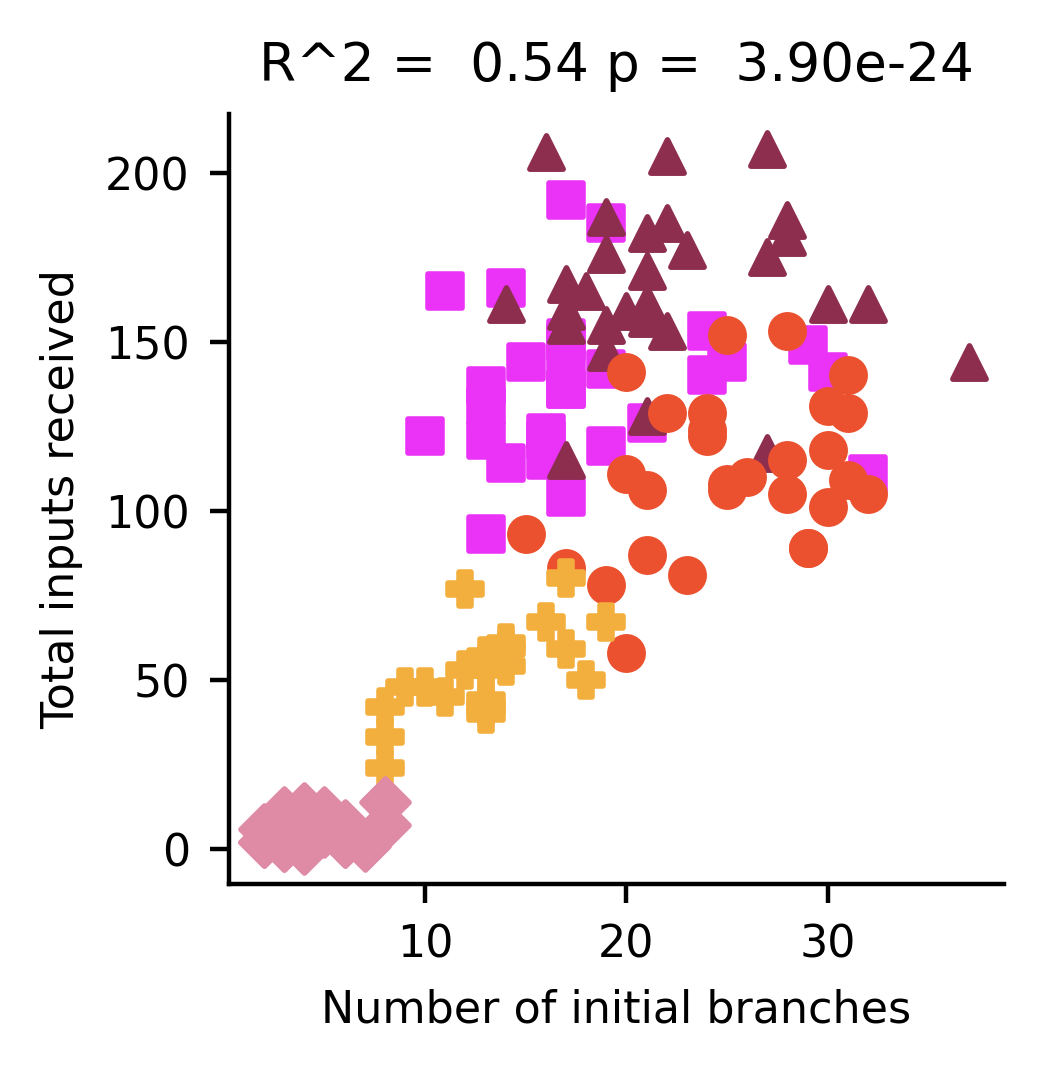

In [13]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

data = major_branches
x = 'n_major'
y = 'total_inputs'

display(f"Corr between {x} and {y}")
X = data[x]
X = sm.add_constant(X)
Y = data[y]

model = sm.OLS(Y, X)
results = model.fit()
display(results.summary())

#ax = sns.regplot(x=x, y=y, data=data, scatter=False, color='k', ci=95)
for st, rows in data.groupby('subtype'):
    x_vars = rows[x]
    y_vars = rows[y]
    ax.scatter(x_vars, y_vars, marker=m[st], c=cm[st], label=f"{st[0] + st.split('_')[1]}")

ax.set_title(f'R^2 = {results.rsquared: .02f} p = {results.f_pvalue: .2e}')
ax.set_xlabel('Number of initial branches')
ax.set_ylabel('Total inputs received')
#ax.legend()

fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_totalinputs-v-initial_2Dscatter.svg')
fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_totalinputs-v-initial_2Dscatter.png')

'Corr between n_major and R1-6_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            R1-6_inputs   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     114.3
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.13e-19
Time:                        17:32:29   Log-Likelihood:                -685.56
No. Observations:                 136   AIC:                             1375.
Df Residuals:                     134   BIC:                             1381.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6310      7.131      0.790      0.431      -8.473      19.735
n_major        4.0275      0.377     10.692      0.000       3.283       4.773
==============================================================================
Omnibus:                        9.633   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.477
Skew:                           0.595   Prob(JB):                      0.00875
Kurtosis:                       2.494   Cond. No.                         41.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

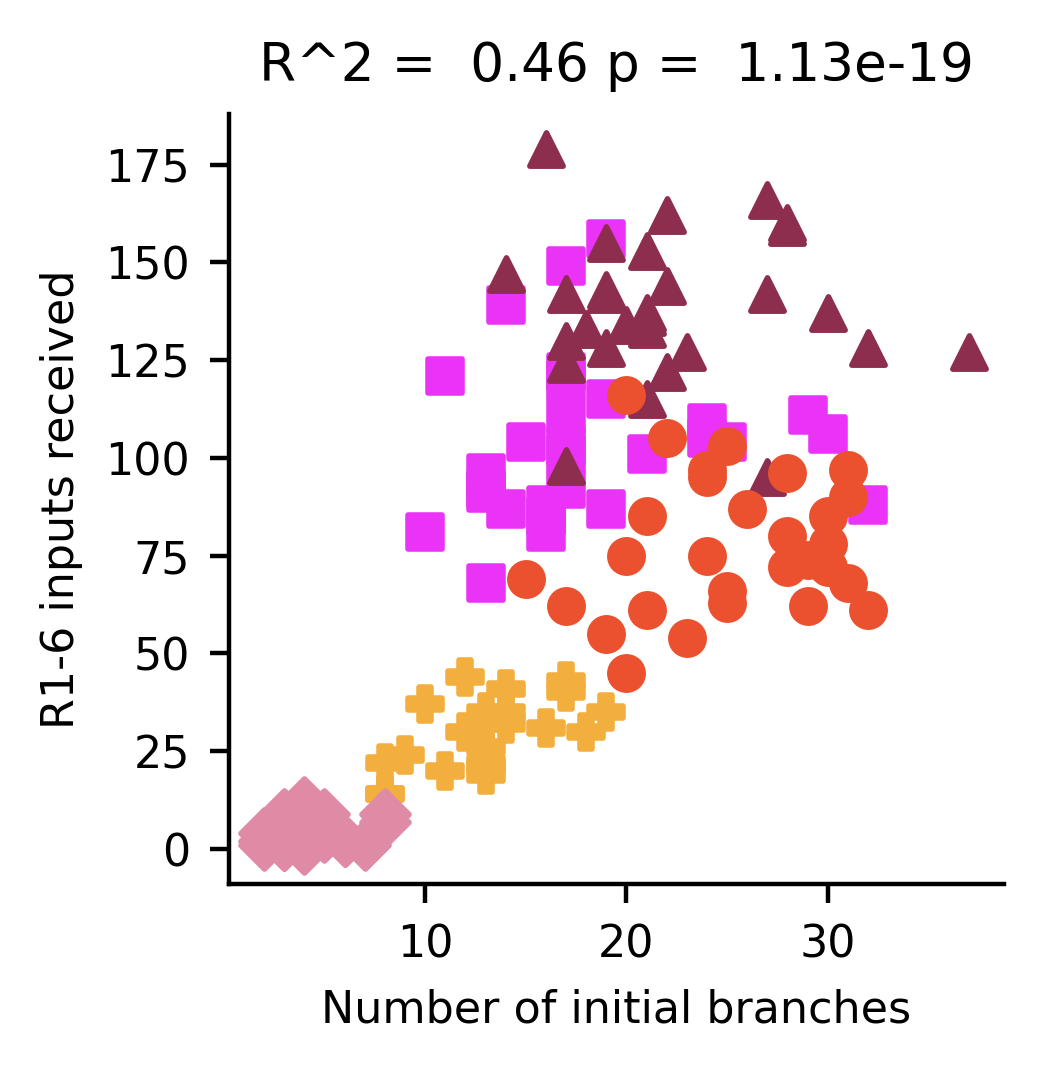

In [14]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

data = major_branches
x = 'n_major'
y = 'R1-6_inputs'

display(f"Corr between {x} and {y}")
X = data[x]
X = sm.add_constant(X)
Y = data[y]

model = sm.OLS(Y, X)
results = model.fit()
display(results.summary())

#ax = sns.regplot(x=x, y=y, data=data, scatter=False, color='k', ci=95)
for st, rows in data.groupby('subtype'):
    x_vars = rows[x]
    y_vars = rows[y]
    ax.scatter(x_vars, y_vars, marker=m[st], c=cm[st], label=f"{st[0] + st.split('_')[1]}")

ax.set_title(f'R^2 = {results.rsquared: .02f} p = {results.f_pvalue: .2e}')
ax.set_xlabel('Number of initial branches')
ax.set_ylabel('R1-6 inputs received')

fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_R1-6inputs-v-initial_2Dscatter.svg')
fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_R1-6inputs-v-initial_2Dscatter.png')

'Corr between mean_strahl and total_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_inputs   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     111.4
Date:                Tue, 11 May 2021   Prob (F-statistic):           2.50e-19
Time:                        17:32:30   Log-Likelihood:                -711.22
No. Observations:                 136   AIC:                             1426.
Df Residuals:                     134   BIC:                             1432.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -13.0695     11.182     -1.169      0.245     -35.186       9.047
mean_strahl    35.4479      3.358     10.555      0.000      28.806      42.090
==============================================================================
Omnibus:                        5.302   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                2.954
Skew:                          -0.119   Prob(JB):                        0.228
Kurtosis:                       2.318   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

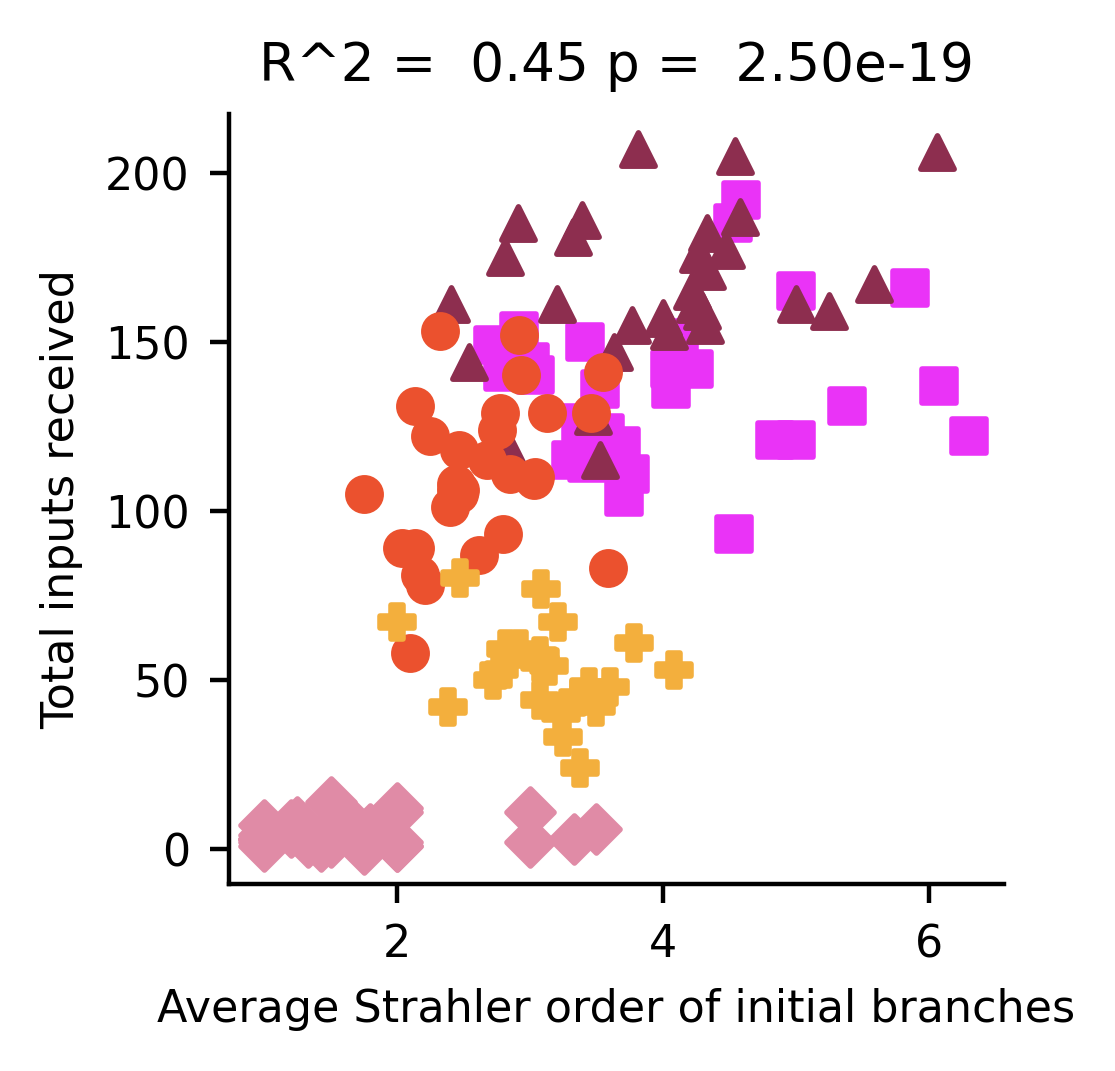

In [15]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

data = major_branches
x = 'mean_strahl'
y = 'total_inputs'

display(f"Corr between {x} and {y}")
X = data[x]
X = sm.add_constant(X)
Y = data[y]

model = sm.OLS(Y, X)
results = model.fit()
display(results.summary())

#ax = sns.regplot(x=x, y=y, data=data, scatter=False, color='k', ci=95)
for st, rows in data.groupby('subtype'):
    x_vars = rows[x]
    y_vars = rows[y]
    ax.scatter(x_vars, y_vars, marker=m[st], c=cm[st], label=f"{st[0] + st.split('_')[1]}")

ax.set_title(f'R^2 = {results.rsquared: .02f} p = {results.f_pvalue: .2e}')
ax.set_xlabel('Average Strahler order of initial branches')
ax.set_ylabel('Total inputs received')

fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_strahl-v-inputs_2Dscatter.svg')
fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_strahl-v-inputs_2Dscatter.png')


'Corr between mean_strahl and R1-6_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            R1-6_inputs   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     108.7
Date:                Tue, 11 May 2021   Prob (F-statistic):           5.32e-19
Time:                        17:32:30   Log-Likelihood:                -687.12
No. Observations:                 136   AIC:                             1378.
Df Residuals:                     134   BIC:                             1384.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -17.9175      9.367     -1.913      0.058     -36.444       0.609
mean_strahl    29.3269      2.813     10.425      0.000      23.763      34.891
==============================================================================
Omnibus:                        2.920   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.232   Jarque-Bera (JB):                2.091
Skew:                          -0.121   Prob(JB):                        0.352
Kurtosis:                       2.443   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

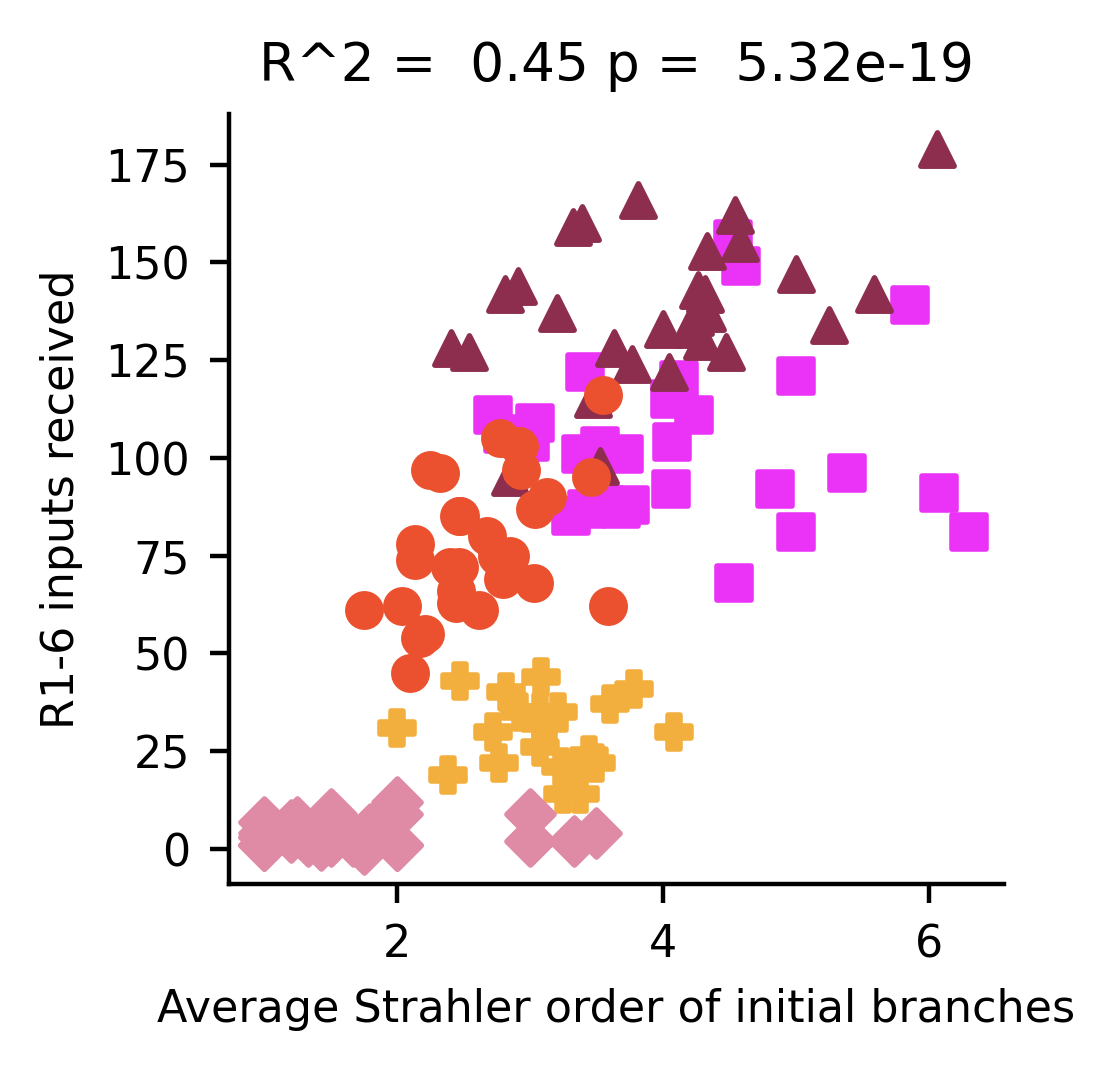

In [16]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

data = major_branches
x = 'mean_strahl'
y = 'R1-6_inputs'

display(f"Corr between {x} and {y}")
X = data[x]
X = sm.add_constant(X)
Y = data[y]

model = sm.OLS(Y, X)
results = model.fit()
display(results.summary())

#ax = sns.regplot(x=x, y=y, data=data, scatter=False, color='k', ci=95)
for st, rows in data.groupby('subtype'):
    x_vars = rows[x]
    y_vars = rows[y]
    ax.scatter(x_vars, y_vars, marker=m[st], c=cm[st], label=f"{st[0] + st.split('_')[1]}")

ax.set_title(f'R^2 = {results.rsquared: .02f} p = {results.f_pvalue: .2e}')
ax.set_xlabel('Average Strahler order of initial branches')
ax.set_ylabel('R1-6 inputs received')

fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_strahl-v-inputs_2Dscatter.svg')
fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_strahl-v-inputs_2Dscatter.png')


'Corr between mean_strahl and R1436_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           R1436_inputs   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     108.8
Date:                Tue, 11 May 2021   Prob (F-statistic):           5.12e-19
Time:                        17:32:31   Log-Likelihood:                -631.13
No. Observations:                 136   AIC:                             1266.
Df Residuals:                     134   BIC:                             1272.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -16.9529      6.206     -2.732      0.007     -29.227      -4.679
mean_strahl    19.4414      1.864     10.432      0.000      15.755      23.127
==============================================================================
Omnibus:                        3.312   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                2.102
Skew:                          -0.054   Prob(JB):                        0.350
Kurtosis:                       2.401   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

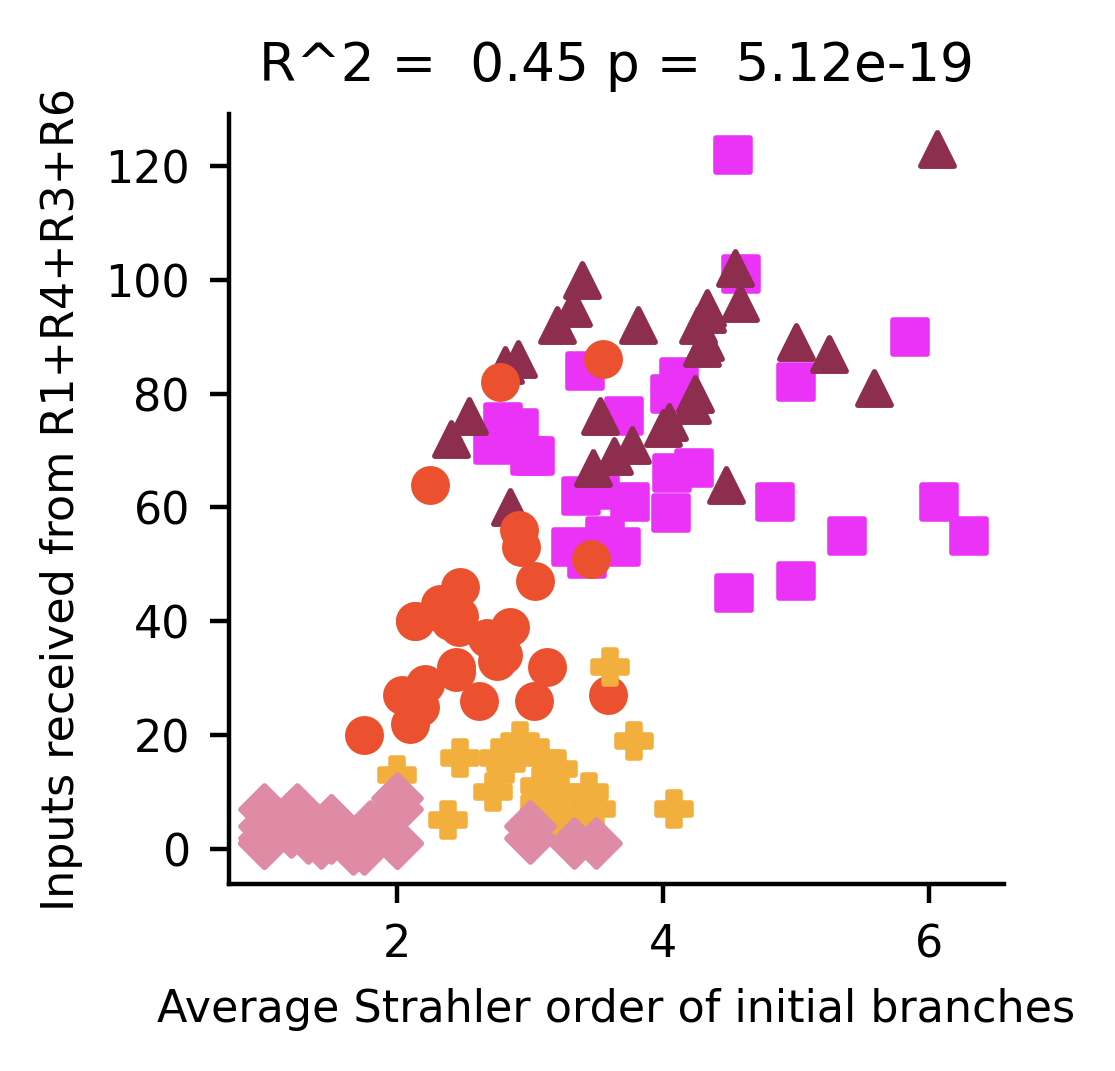

In [17]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

data = major_branches
x = 'mean_strahl'
y = 'R1436_inputs'

display(f"Corr between {x} and {y}")
X = data[x]
X = sm.add_constant(X)
Y = data[y]

model = sm.OLS(Y, X)
results = model.fit()
display(results.summary())

#ax = sns.regplot(x=x, y=y, data=data, scatter=False, color='k', ci=95)
for st, rows in data.groupby('subtype'):
    x_vars = rows[x]
    y_vars = rows[y]
    ax.scatter(x_vars, y_vars, marker=m[st], c=cm[st], label=f"{st[0] + st.split('_')[1]}")

ax.set_title(f'R^2 = {results.rsquared: .02f} p = {results.f_pvalue: .2e}')
ax.set_xlabel('Average Strahler order of initial branches')
ax.set_ylabel('Inputs received from R1+R4+R3+R6')

fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_strahl-v-R1436inputs_2Dscatter.svg')
fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_strahl-v-R1436inputs_2Dscatter.png')


'Corr between n_major and mean_strahl'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            mean_strahl   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     6.083
Date:                Tue, 11 May 2021   Prob (F-statistic):             0.0149
Time:                        17:32:31   Log-Likelihood:                -210.39
No. Observations:                 136   AIC:                             424.8
Df Residuals:                     134   BIC:                             430.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6441      0.217     12.205      0.000       2.216       3.073
n_major        0.0282      0.011      2.466      0.015       0.006       0.051
==============================================================================
Omnibus:                        7.675   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.793
Skew:                           0.586   Prob(JB):                       0.0203
Kurtosis:                       3.032   Cond. No.                         41.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

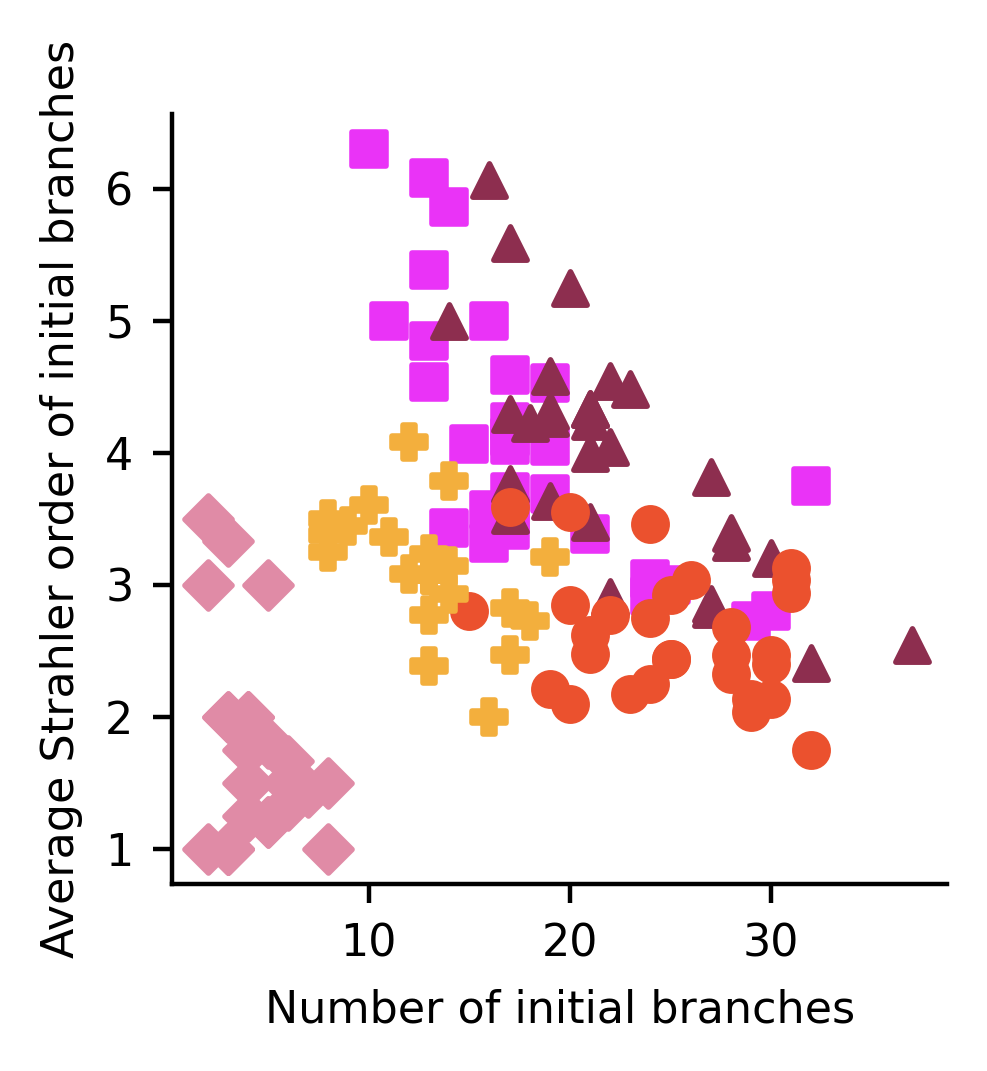

In [18]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

data = major_branches
x = 'n_major'
y = 'mean_strahl'

display(f"Corr between {x} and {y}")
X = data[x]
X = sm.add_constant(X)
Y = data[y]

model = sm.OLS(Y, X)
results = model.fit()
display(results.summary())

#ax = sns.regplot(x=x, y=y, data=data, scatter=False, color='k', ci=95)
for st, rows in data.groupby('subtype'):
    x_vars = rows[x]
    y_vars = rows[y]
    ax.scatter(x_vars, y_vars, marker=m[st], c=cm[st], label=f"{st[0] + st.split('_')[1]}")

#ax.set_title(f'R^2 = {results.rsquared: .02f} p = {results.f_pvalue: .2e}')
ax.set_xlabel('Number of initial branches')
ax.set_ylabel('Average Strahler order of initial branches')


fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_strahl-v-initial_2Dscatter.svg')
fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_strahl-v-initial_2Dscatter.png')


<ipython-input-19-ec730f803e01>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


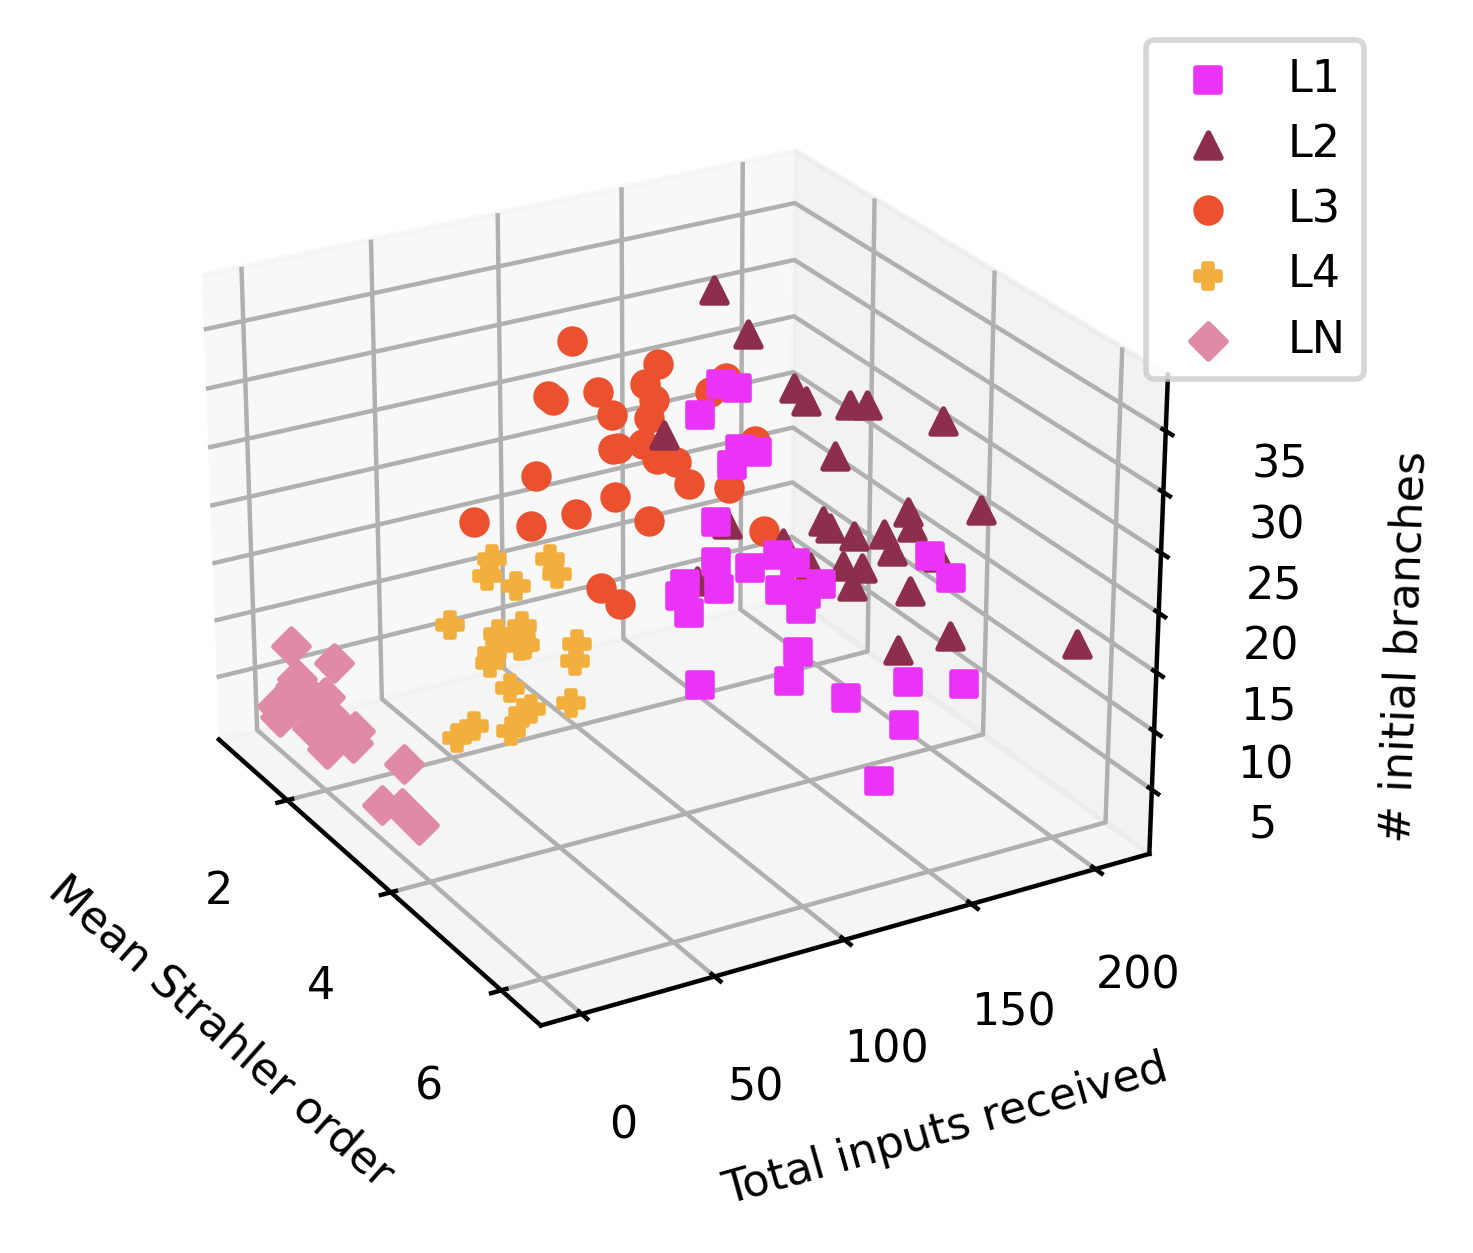

In [19]:
fig = plt.figure(figsize=[3.5, 3.5])
ax = fig.gca(projection='3d')
ax.set_xlabel('Mean Strahler order')
ax.set_ylabel('Total inputs received')
ax.set_zlabel('# initial branches')


c = subtype_cm()

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

for pre, rows in major_branches.groupby('subtype'):
    
    x = rows['mean_strahl']
    y = rows['total_inputs']
    z = rows['n_major']
    
    
    ax.scatter(x, y, z, 
               label=f"L{pre.split('_')[1]}", 
               marker=m[pre],
               c=c[pre], 
               alpha=1.0, 
               depthshade=False)
    
    #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0.)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.invert_zaxis()
ax.view_init(elev=25, azim=-30)

plt.show()


fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_morph_3Dscatter_smaller.svg')
fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_morph_3Dscatter_smaller.png')

In [ ]:
fig = plt.figure(figsize=[4.6, 4.6])
ax = fig.gca(projection='3d')
ax.set_ylabel('Mean Strahler order')
ax.set_zlabel('# lamina inputs received')
ax.set_xlabel('# main branches')


c = subtype_cm()

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

for pre, rows in major_branches.groupby('subtype'):
    
    y = rows['mean_strahl']
    z = rows['total_inputs']
    x = rows['n_major']
    
    
    ax.scatter(x, y, z, 
               label=f"L{pre.split('_')[1]}", 
               marker=m[pre],
               c=c[pre], 
               alpha=0.8, 
               depthshade=False)
    
    #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0.)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.invert_zaxis()
ax.view_init(elev=20, azim=200)

plt.show()

# if save_figs:
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.svg')
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.png')

In [ ]:
fig = plt.figure(figsize=[4.6, 4.6])
ax = fig.gca(projection='3d')
ax.set_xlabel('Mean Strahler order')
ax.set_ylabel('# lamina inputs received')
ax.set_zlabel('Total branch len')

c = subtype_cm()

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

for pre, rows in major_branches.groupby('subtype'):
    
    x = rows['mean_strahl']
    y = rows['total_inputs']
    z = rows['total_branch_len']
    
    
    ax.scatter(x, y, z, 
               label=f"L{pre.split('_')[1]}", 
               marker=m[pre],
               c=c[pre], 
               alpha=0.8, 
               depthshade=False)
    
    #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0.)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.invert_yaxis()
ax.view_init(elev=40, azim=-15)

plt.show()

# if save_figs:
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.svg')
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.png')

In [ ]:
fig = plt.figure(figsize=[4.6, 4.6])
ax = fig.gca(projection='3d')
ax.set_xlabel('Mean Strahler order')
ax.set_ylabel('# lamina inputs received')
ax.set_zlabel('Total branch len')

c = subtype_cm()

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

for pre, rows in major_branches.groupby('subtype'):
    
    x = rows['mean_strahl']
    y = rows['total_inputs']
    z = rows['total_branch_len']/rows['n_major']
    
    
    ax.scatter(x, y, z, 
               label=f"L{pre.split('_')[1]}", 
               marker=m[pre],
               c=c[pre], 
               alpha=0.8, 
               depthshade=False)
    
    #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0.)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.invert_yaxis()
ax.view_init(elev=20, azim=-15)

plt.show()

# if save_figs:
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.svg')
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.png')

In [ ]:
fig, axes = plt.subplots(5, sharex=True, figsize=[4, 8])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0
cm = subtype_cm()
for st, neurons in major_branches.groupby('subtype'):
    data = neurons['total_branch_len']
    
    axes[i].hist(data/1000.0, color=cm[st])
    axes[i].set_ylabel(f"# {st[0] + st[-1]}")
    #axes[i].set_yticklabels(np.arange(0, 10, 2))
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1
#     sns.histplot(segs, x='len', ax=axes[i, 1])
#     sns.histplot(segs, x='strahl_ord', ax=axes[i, 2])
axes[-1].set_xlabel('Total branch length (microns)')

In [ ]:
fig, axes = plt.subplots(5, sharex=True, figsize=[4, 8])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0
cm = subtype_cm()
for st, neurons in major_branches.groupby('subtype'):
    data = neurons['total_branch_len']/neurons['n_major']
    
    axes[i].hist(data/1000.0, color=cm[st])
    axes[i].set_ylabel(f"# {st[0] + st[-1]}")
    #axes[i].set_yticklabels(np.arange(0, 10, 2))
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1
#     sns.histplot(segs, x='len', ax=axes[i, 1])
#     sns.histplot(segs, x='strahl_ord', ax=axes[i, 2])
axes[-1].set_xlim([0, 15])
axes[-1].set_xlabel('Average branch length (microns)')

In [ ]:
data = major_branches
x_vars=['n_major', 'mean_strahl']
y_vars=['total_inputs', 'R1-6_inputs', 'R1436_inputs', 'R25_inputs']

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

g = sns.pairplot(data, hue='subtype', markers=m, palette=subtype_cm(), 
             x_vars=x_vars, 
             y_vars=y_vars)

g.savefig('/mnt/home/nchua/Dropbox/lamina_figures/210505_LMC_morp_vs_cx.svg')


In [ ]:
data = major_branches
these_vars=['n_major', 'mean_strahl', 'total_inputs']

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

g = sns.pairplot(data, hue='subtype', markers=m, palette=subtype_cm(), 
             x_vars=these_vars, 
             y_vars=these_vars)
g.savefig('/mnt/home/nchua/Dropbox/lamina_figures/210505_LMC_morp_vs_cx-pair.svg')

In [ ]:
for x in x_vars:
    for y in y_vars:
        display(f"Corr between {x} and {y}")
        X = data[x]
        X = sm.add_constant(X)
        Y = data[y]

        model = sm.OLS(Y, X)
        results = model.fit()

        display(results.summary())
        
